<a href="https://colab.research.google.com/github/Bantami/All-Optical-QPM/blob/main/Colab/cnn_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setting up Scripts


*   Downloading repository, dataset and models
*   Install pip packages


In [1]:
!git clone https://github.com/Bantami/All-Optical-QPM.git

!chmod 755 All-Optical-QPM/colab_setup.sh
!All-Optical-QPM/colab_setup.sh

Cloning into 'All-Optical-QPM'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 91 (delta 43), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (91/91), done.
     |████████████████████████████████| 631 kB 33.3 MB/s 
     |████████████████████████████████| 232 kB 12.3 MB/s 
     |████████████████████████████████| 49.9 MB 71 kB/s 
Downloading...
From: https://drive.google.com/uc?id=1ickDfs6bA-YM7RQSaMPRqFnC7YApjW8e
To: /content/hela.zip
100% 303M/303M [00:01<00:00, 277MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tHBWjNJPRHf1VX0XJicLIKs8av43_TPz
To: /content/models.zip
100% 3.27M/3.27M [00:00<00:00, 284MB/s]


### Import Libraries

In [2]:
import sys
sys.path.append('All-Optical-QPM')

from torch import nn
from collections import OrderedDict
from torchvision.utils import make_grid
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from torchvision import datasets, transforms
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import glob
import os
import json

from modules.dataloaders import *
from modules.diffraction import *
from modules.other_models import *
from modules.eval_metrics import *
from modules.vis_utils import *

## Use Pretrained Models: Model Selection and Loading

In [3]:
pretrained_models = {
    'MNIST'       : 'MNIST_cnn',
    'HeLa [0,Pi]' : 'Hela_pi_cnn',
    'HeLa [0,2Pi]': 'Hela_2pi_cnn',

} 

In [4]:
def initiate_model(model_name):
  '''
      Function to initiate the model and dataloaders

        Args:
              model_name  : The name of the model - 'MNIST', 'HeLa [0,Pi]', 'HeLa [0,2Pi]'
              
        Returns:
              cfg         : Configurations dictionary
              model       : Initiated model
              val_loader  : Dataloader containing the test images
  '''

  model = pretrained_models[model_name] # Selecting a pretrained model

  folder = 'models/'

  file_name = f'{model}.pth'

  saved = torch.load(folder + file_name,map_location='cuda:0')

  cfg   = saved['cfg']
  cfg['device'] = 'cuda:0'

  if 'last_bias' not in cfg.keys() or 'output_scale' not in cfg.keys(): 
    # Adding missing configurations required for the current model implementation function. Default configs are used
    cfg['last_bias'] = True
    cfg['all_bias'] = False
    cfg['output_scale'] = 1
    cfg['output_scale_learnable'] = False

  model = eval(cfg['model'])(cfg).to(cfg['device'])
  model.load_state_dict(saved['state_dict'])
  model.eval()

  torch.manual_seed(cfg['torch_seed'])

  shrinkFactor = cfg['shrink_factor'] if 'shrink_factor' in cfg else 1
  img_size     = cfg['img_size']
  angle_max    = eval(cfg['angle_max'])
  inp_circular = cfg['input_circular'] if 'input_circular' in cfg.keys() else False # If the input field is propagated through a circular aperture
  device = cfg['device']

  if(shrinkFactor!=1):
      # To obtain the starting position and ending position of the original image within the padded image
      csize = int(img_size/shrinkFactor)
      spos  = int((img_size - csize)/2)
      epos  = spos + csize
  else:
      spos = 0
      epos = img_size
      
  dataloader = eval(cfg['get_dataloaders'])
  print(cfg['get_dataloaders'])

  train_loader, val_loader =  dataloader(cfg['img_size'], cfg['train_batch_size'], cfg['torch_seed'],  task_type= cfg['task_type'], shrinkFactor = shrinkFactor, cfg = cfg)
  print(len(val_loader))

  cfg['spos'] = spos
  cfg['epos'] = epos

  return cfg, model, val_loader

### Run Inference on Unseen Data

In [8]:
def inference(cfg, model, val_loader):
  '''
      Function to infer on unseen data

        Args:
              cfg         : Configurations dictionary
              model       : Initiated model
              val_loader  : Dataloader containing the test images              
  '''

  spos = cfg['spos']
  epos = cfg['epos']
  angle_max    = eval(cfg['angle_max'])
  device = cfg['device']
  ssim_scores = []

  for idx, (x, y) in enumerate(val_loader): # Test loop   
      gt = x[:,0].to(cfg['device']) # Groung truth image (input)
      pred_img,out_scale = model(gt) 

      
      pred_img = pred_img[:,spos:epos,spos:epos] # Crop the reconstructed image
      gt       = gt[:,spos:epos,spos:epos]       # Crop the groundtruth image
      
      pred_out = out_scale * pred_img.abs()**2

      if(cfg['get_dataloaders']=="get_mnist_dataloaders"):
          gt_angle = gt.angle()/angle_max
      else:
          # CLIP ANGLE TO -> [0, angle_max]
          y = torch.clip(y, min= 0, max= angle_max).to(device)
          gt_angle = y[:,0].to(cfg['device'])[:,spos:epos,spos:epos] / angle_max
          
      ssim_scores.append(ssim_pytorch(pred_out.float(), gt_angle.float(), k= 11,range_independent=False))
      

  print("========\nMean SSIM = ", np.mean(ssim_scores))

  # Plotting ground truth images
  gt_img_set = gt.unsqueeze(dim= 1)[10:14]

  k = gt_img_set.angle().detach().cpu()
  k = cv2.cvtColor(make_grid(k, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY)%(2*np.pi)


  plt.figure(figsize=(5,5))
  plt.title("Grountruth Phase")
  plt.imshow(k)

  # Plotting the corresponding reconstructed images
  pred_img_set = pred_out.unsqueeze(dim= 1)[10:14]
  

  plt.figure(figsize=(5,5))
  plt.imshow(cv2.cvtColor(make_grid(pred_img_set.abs().detach().cpu(), nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin = 0, vmax =1)
  plt.title('Reconstructed : Intensity')

#### MNIST 

get_mnist_dataloaders
187
Mean SSIM =  0.9727393309062815


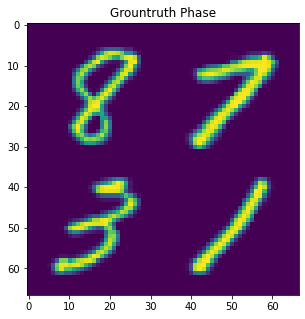

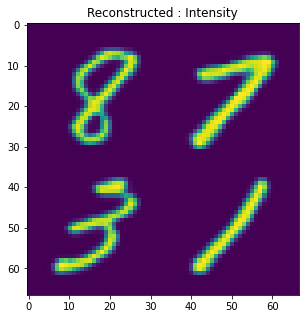

In [9]:
cfg, model, val_loader = initiate_model('MNIST')
inference(cfg, model, val_loader)

#### HeLa [0, $\pi$]

get_qpm_np_dataloaders
68
Mean SSIM =  0.9051738451508915


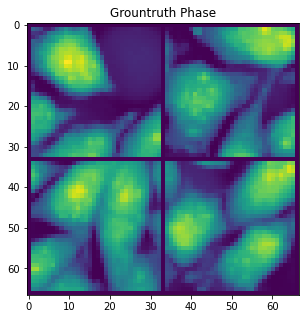

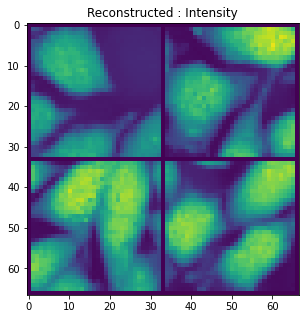

In [10]:
cfg, model, val_loader = initiate_model('HeLa [0,Pi]')
inference(cfg, model, val_loader)

#### HeLa [0, $2\pi$]

get_qpm_np_dataloaders
68
Mean SSIM =  0.7059781560126472


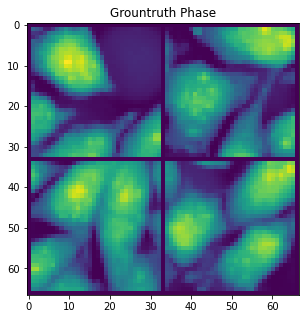

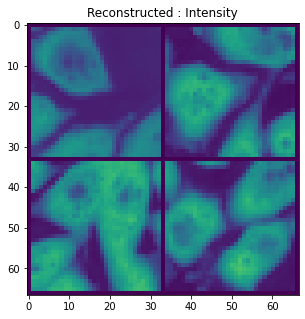

In [11]:
cfg, model, val_loader = initiate_model('HeLa [0,2Pi]')
inference(cfg, model, val_loader)